In [17]:
import os
import shutil
import random
import numpy as np
from PIL import Image
import time
from collections import defaultdict
import sys
import argparse
from pathlib import Path
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.datasets as datasets
from sklearn.metrics import confusion_matrix, classification_report

Check for GPU

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data preparations

Extracting the dimensions of the images

In [ ]:
def print_image_dimensions(data_dir):
    class_dimensions = {}
    
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        
        if os.path.isdir(class_path):
            dimensions = {}
            
            for file in os.listdir(class_path):
                if file.lower().endswith(('png', 'jpg', 'jpeg', 'gif', 'bmp')):
                    file_path = os.path.join(class_path, file)
                    
                    with Image.open(file_path) as img:
                        width, height = img.size
                        dim = (width, height)
                        dimensions[dim] = dimensions.get(dim, 0) + 1
            
            class_dimensions[class_name] = dimensions
    
    for class_name, dims in class_dimensions.items():
        print(f"Class: {class_name}")
        for dim, count in dims.items():
            print(f"  Dimension: {dim[0]}x{dim[1]}, Count: {count}")

print_image_dimensions('data')

Class: glioma
  Dimension: 512x512, Count: 1621
Class: meningioma
  Dimension: 440x278, Count: 1
  Dimension: 257x307, Count: 2
  Dimension: 228x221, Count: 2
  Dimension: 212x237, Count: 4
  Dimension: 528x581, Count: 2
  Dimension: 295x394, Count: 2
  Dimension: 219x234, Count: 2
  Dimension: 262x308, Count: 2
  Dimension: 206x249, Count: 2
  Dimension: 530x526, Count: 2
  Dimension: 455x500, Count: 5
  Dimension: 200x223, Count: 4
  Dimension: 472x546, Count: 2
  Dimension: 441x427, Count: 2
  Dimension: 540x568, Count: 1
  Dimension: 507x605, Count: 2
  Dimension: 290x339, Count: 2
  Dimension: 591x650, Count: 2
  Dimension: 534x674, Count: 2
  Dimension: 300x345, Count: 2
  Dimension: 306x306, Count: 2
  Dimension: 374x370, Count: 2
  Dimension: 201x207, Count: 2
  Dimension: 291x340, Count: 2
  Dimension: 630x423, Count: 2
  Dimension: 318x354, Count: 2
  Dimension: 554x554, Count: 5
  Dimension: 315x341, Count: 2
  Dimension: 286x356, Count: 2
  Dimension: 278x306, Count: 2
  Di

Resizing the images

In [ ]:
def find_min_dimensions(data_dir):
    min_width, min_height = float('inf'), float('inf')

    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        
        if os.path.isdir(class_path):
            for file in os.listdir(class_path):
                if file.lower().endswith(('png', 'jpg', 'jpeg', 'gif', 'bmp')):
                    file_path = os.path.join(class_path, file)
                    
                    with Image.open(file_path) as img:
                        width, height = img.size
                        min_width = min(min_width, width)
                        min_height = min(min_height, height)

    return min_width, min_height

def resize_images(data_dir, output_dir, target_size):
    os.makedirs(output_dir, exist_ok=True)

    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        output_class_path = os.path.join(output_dir, class_name)
        os.makedirs(output_class_path, exist_ok=True)
        
        if os.path.isdir(class_path):
            for file in os.listdir(class_path):
                if file.lower().endswith(('png', 'jpg', 'jpeg', 'gif', 'bmp')):
                    file_path = os.path.join(class_path, file)
                    output_file_path = os.path.join(output_class_path, file)
                    
                    with Image.open(file_path) as img:
                        resized_img = img.resize(target_size, Image.LANCZOS)

                        # Convert RGBA and P mode images to RGB before saving as JPEG
                        if resized_img.mode in ("RGBA", "P"):
                            resized_img = resized_img.convert("RGB")

                        resized_img.save(output_file_path)

    print(f"All images have been resized to {target_size} and saved in '{output_dir}'.")

# Step 1: Find the smallest dimensions
min_w, min_h = find_min_dimensions('data')
print(f"Minimum dimensions found: {min_w}x{min_h}")

# Step 2: Resize images
resize_images('data', 'processed data', (min_w, min_h))

Minimum dimensions found: 150x168
All images have been resized to (150, 168) and saved in 'processed data'.


Detecting the color mode of the images

In [7]:
def get_image_modes(data_dir):
    class_dirs = [d for d in data_dir.iterdir() if d.is_dir()]
    if not class_dirs:
        print(f"No class directories found in {data_dir}")
        return

    stats = {}
    overall_stats = defaultdict(int)
    valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp'}

    for class_dir in class_dirs:
        class_name = class_dir.name
        print(f"Processing class: {class_name}")
        
        class_stats = defaultdict(int)
        image_files = [f for f in class_dir.iterdir() if f.suffix.lower() in valid_extensions]
        
        for idx, img_path in enumerate(image_files, 1):
            try:
                with Image.open(img_path) as img:
                    mode = img.mode
            except Exception as e:
                print(f"\nError processing {img_path}: {str(e)}", file=sys.stderr)
                continue

            class_stats[mode] += 1
            overall_stats[mode] += 1

            if idx % 100 == 0:
                print(f"Processed {idx} images...")

        stats[class_name] = class_stats
        print(f"Completed {class_name}. Processed {len(image_files)} images\n")

    return stats, overall_stats

def print_report(stats, overall_stats):
    print("\nClass-wise breakdown:")
    for class_name, class_stats in stats.items():
        print(f"\nClass: {class_name}")
        for mode, count in class_stats.items():
            print(f"  {mode}: {count} images")
        print(f"  Total: {sum(class_stats.values())} images")

    print("\nOverall statistics:")
    for mode, count in overall_stats.items():
        print(f"  {mode}: {count} images")
    print(f"  Total: {sum(overall_stats.values())} images")

In [8]:
data_dir = Path('processed data')

if not data_dir.exists():
    print(f"Data directory {data_dir} does not exist!")
    sys.exit(1)

stats, overall_stats = get_image_modes(data_dir)
print_report(stats, overall_stats)

Processing class: glioma
Processed 100 images...
Processed 200 images...
Processed 300 images...
Processed 400 images...
Processed 500 images...
Processed 600 images...
Processed 700 images...
Processed 800 images...
Processed 900 images...
Processed 1000 images...
Processed 1100 images...
Processed 1200 images...
Processed 1300 images...
Processed 1400 images...
Processed 1500 images...
Processed 1600 images...
Completed glioma. Processed 1621 images

Processing class: meningioma
Processed 100 images...
Processed 200 images...
Processed 300 images...
Processed 400 images...
Processed 500 images...
Processed 600 images...
Processed 700 images...
Processed 800 images...
Processed 900 images...
Processed 1000 images...
Processed 1100 images...
Processed 1200 images...
Processed 1300 images...
Processed 1400 images...
Processed 1500 images...
Processed 1600 images...
Completed meningioma. Processed 1645 images

Processing class: notumor
Processed 100 images...
Processed 200 images...
Proc

Converting the RGB images to 

In [9]:
def convert_grayscale_to_rgb(data_dir):
    valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp'}
    converted_count = 0
    error_count = 0

    for class_dir in data_dir.iterdir():
        if not class_dir.is_dir():
            continue

        print(f"\nProcessing class: {class_dir.name}")
        image_files = [f for f in class_dir.iterdir() if f.suffix.lower() in valid_extensions]

        for img_path in image_files:
            try:
                with Image.open(img_path) as img:
                    if img.mode == 'L':
                        # Convert grayscale to RGB
                        rgb_img = img.convert('RGB')
                        
                        # Preserve metadata
                        kwargs = {}
                        if 'exif' in img.info:
                            kwargs['exif'] = img.info['exif']
                        
                        # Save converted image
                        rgb_img.save(img_path, **kwargs)
                        converted_count += 1
                        print(f"✓ Converted {img_path.name}")
                    else:
                        print(f"→ Skipped {img_path.name} (already {img.mode})")

            except Exception as e:
                error_count += 1
                print(f"✗ Error processing {img_path}: {str(e)}", file=sys.stderr)
                continue

    return converted_count, error_count

# Configuration
data_dir = Path('processed data')  # Update path if needed

if not data_dir.exists():
    print(f"Data directory {data_dir} does not exist!")
    sys.exit(1)

In [10]:
# Safety warnings
print("\n" + "⚠" * 50)
print("CRITICAL WARNING: This will PERMANENTLY convert grayscale images to RGB")
print("NO BACKUPS WILL BE CREATED")
print("THERE IS NO UNDO OPTION")
print("⚠" * 50 + "\n")

confirm = input("Type 'CONFIRM' to proceed: ").strip()
if confirm != "CONFIRM":
    print("Conversion cancelled")
    sys.exit(0)

# Final confirmation
print("\nLAST CHANCE TO CANCEL!")
confirm_final = input("Are you ABSOLUTELY sure? (y/N): ").lower()
if confirm_final != 'y':
    print("Conversion cancelled")
    sys.exit(0)

# Run conversion
converted, errors = convert_grayscale_to_rgb(data_dir)

# Results
print("\nConversion report:")
print(f"Successfully converted: {converted} grayscale images to RGB")
print(f"Errors encountered: {errors} images")
print("Operation complete. Original grayscale images are gone forever.")


⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠
CRITICAL WARNING: This will PERMANENTLY convert grayscale images to RGB
NO BACKUPS WILL BE CREATED
THERE IS NO UNDO OPTION
⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠


LAST CHANCE TO CANCEL!

Processing class: glioma
→ Skipped Te-glTr_0000.jpg (already RGB)
→ Skipped Te-glTr_0001.jpg (already RGB)
→ Skipped Te-glTr_0002.jpg (already RGB)
→ Skipped Te-glTr_0003.jpg (already RGB)
→ Skipped Te-glTr_0004.jpg (already RGB)
→ Skipped Te-glTr_0005.jpg (already RGB)
→ Skipped Te-glTr_0006.jpg (already RGB)
→ Skipped Te-glTr_0007.jpg (already RGB)
→ Skipped Te-glTr_0008.jpg (already RGB)
→ Skipped Te-glTr_0009.jpg (already RGB)
→ Skipped Te-gl_0010.jpg (already RGB)
→ Skipped Te-gl_0011.jpg (already RGB)
→ Skipped Te-gl_0012.jpg (already RGB)
→ Skipped Te-gl_0013.jpg (already RGB)
→ Skipped Te-gl_0014.jpg (already RGB)
→ Skipped Te-gl_0015.jpg (already RGB)
→ Skipped Te-gl_0016.jpg (already RGB)
→ Skipped Te-gl_0017.jpg (already RGB)
→

Calculating the total number of images in each class

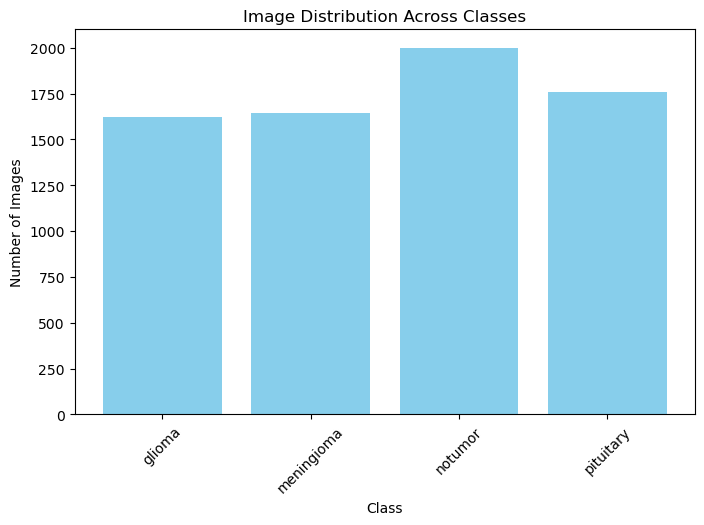

In [12]:
def count_images_in_classes(data_dir):
    class_counts = {}
    
    # Iterate over classes
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        
        # Ensure it's a directory
        if os.path.isdir(class_path):
            # Count the number of image files (assuming common image extensions)
            image_count = sum(1 for file in os.listdir(class_path) 
                              if file.lower().endswith(('png', 'jpg', 'jpeg', 'gif', 'bmp')))
            class_counts[class_name] = image_count
    
    return class_counts

def plot_class_distribution(class_counts):
    classes = list(class_counts.keys())
    counts = list(class_counts.values())
    
    plt.figure(figsize=(8, 5))
    plt.bar(classes, counts, color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title('Image Distribution Across Classes')
    plt.xticks(rotation=45)
    plt.show()

# Count images and plot the distribution
class_counts = count_images_in_classes('processed data')
plot_class_distribution(class_counts)

Spliting the data into train (70%), test(15%) and validation(15%) sets.

In [13]:
def split_data(data_dir, output_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(output_dir, split), exist_ok=True)
    
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        
        if os.path.isdir(class_path):
            images = [file for file in os.listdir(class_path) if file.lower().endswith(('png', 'jpg', 'jpeg', 'gif', 'bmp'))]
            random.shuffle(images)
            
            train_split = int(len(images) * train_ratio)
            val_split = int(len(images) * (train_ratio + val_ratio))
            
            splits = {
                'train': images[:train_split],
                'val': images[train_split:val_split],
                'test': images[val_split:]
            }
            
            for split, files in splits.items():
                split_class_dir = os.path.join(output_dir, split, class_name)
                os.makedirs(split_class_dir, exist_ok=True)
                
                for file in files:
                    shutil.copy(os.path.join(class_path, file), os.path.join(split_class_dir, file))
    
    print('Dataset successfully split into train, val, and test sets.')

# Perform data splitting
split_data('processed data', 'split')

Dataset successfully split into train, val, and test sets.


Calculating the distribution of data into test train and validation sets

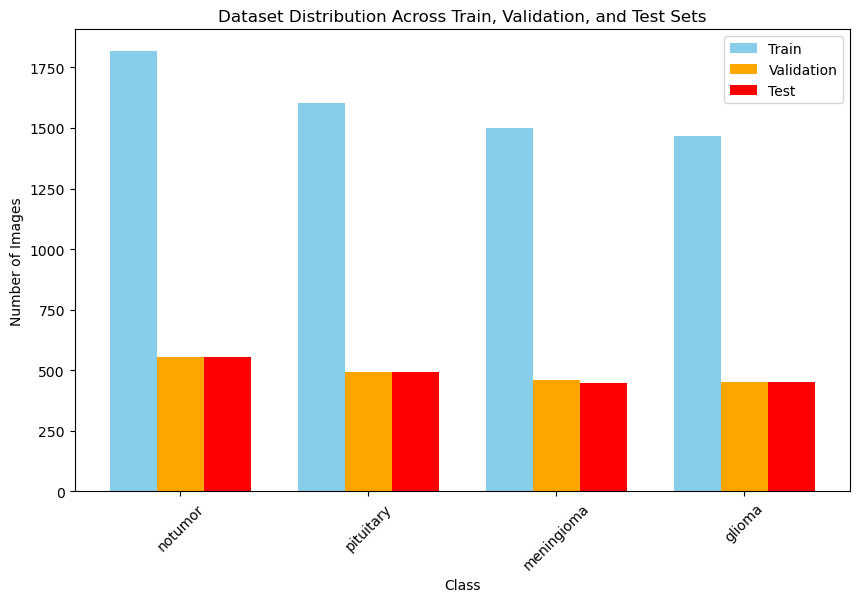

In [14]:
def plot_dataset_distribution(output_dir):
    splits = ['train', 'val', 'test']
    class_counts = {split: {} for split in splits}
    
    for split in splits:
        split_path = os.path.join(output_dir, split)
        
        for class_name in os.listdir(split_path):
            class_path = os.path.join(split_path, class_name)
            if os.path.isdir(class_path):
                class_counts[split][class_name] = len(os.listdir(class_path))
    
    classes = list(set().union(*[class_counts[split].keys() for split in splits]))
    
    train_counts = [class_counts['train'].get(cls, 0) for cls in classes]
    val_counts = [class_counts['val'].get(cls, 0) for cls in classes]
    test_counts = [class_counts['test'].get(cls, 0) for cls in classes]
    
    x = np.arange(len(classes))
    width = 0.25  # Width of bars
    
    plt.figure(figsize=(10, 6))
    plt.bar(x - width, train_counts, width, label='Train', color='skyblue')
    plt.bar(x, val_counts, width, label='Validation', color='orange')
    plt.bar(x + width, test_counts, width, label='Test', color='red')
    
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title('Dataset Distribution Across Train, Validation, and Test Sets')
    plt.xticks(ticks=x, labels=classes, rotation=45)
    plt.legend()
    plt.show()

# Plot dataset distribution
plot_dataset_distribution('split')

## Custom CNN model training

In [5]:
data_dir = "split"
train_dir = f"{data_dir}/train"
val_dir = f"{data_dir}/val"
test_dir = f"{data_dir}/test"

Loading the dataset

In [6]:
train_transform = transforms.Compose([
    transforms.Resize((150, 168)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomResizedCrop((150, 168), scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((150, 168)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_test_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=val_test_transform)

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print("Dataset loading successful!")

Dataset loading successful!


Defining the CNN model

In [7]:
class CNN(nn.Module):
    def __init__(self, num_classes=4):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 18 * 21, 256),  # Adjust dimensions based on input size
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

Initializing the model, loss, and optimizer

In [12]:
model = CNN(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Training Function

In [14]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_accuracy = 100 * val_correct / val_total
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_accuracy)

        end_time = time.time()
        print(f"Epoch {epoch+1}/{epochs}, Time: {end_time - start_time:.2f}s")
        print(f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracy:.2f}%")
        print(f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracy:.2f}%\n")

    return train_losses, val_losses, train_accuracies, val_accuracies

Model training

In [15]:
train_losses, val_losses, train_accuracies, val_accuracies = train(model, train_loader, val_loader, criterion, optimizer, epochs=50)

Epoch 1/50, Time: 37.06s
Train Loss: 1.1194, Train Acc: 51.69%
Val Loss: 0.7501, Val Acc: 68.79%

Epoch 2/50, Time: 19.97s
Train Loss: 0.8770, Train Acc: 63.80%
Val Loss: 0.5972, Val Acc: 75.33%

Epoch 3/50, Time: 20.54s
Train Loss: 0.8177, Train Acc: 66.81%
Val Loss: 0.5650, Val Acc: 75.14%

Epoch 4/50, Time: 21.39s
Train Loss: 0.7568, Train Acc: 69.09%
Val Loss: 0.5917, Val Acc: 75.90%

Epoch 5/50, Time: 20.30s
Train Loss: 0.7225, Train Acc: 70.04%
Val Loss: 0.4720, Val Acc: 82.54%

Epoch 6/50, Time: 20.52s
Train Loss: 0.6661, Train Acc: 72.89%
Val Loss: 0.4384, Val Acc: 85.67%

Epoch 7/50, Time: 21.27s
Train Loss: 0.6386, Train Acc: 74.70%
Val Loss: 0.3932, Val Acc: 86.24%

Epoch 8/50, Time: 22.51s
Train Loss: 0.6023, Train Acc: 76.72%
Val Loss: 0.5070, Val Acc: 81.97%

Epoch 9/50, Time: 20.40s
Train Loss: 0.5455, Train Acc: 79.12%
Val Loss: 0.3498, Val Acc: 88.71%

Epoch 10/50, Time: 21.36s
Train Loss: 0.5415, Train Acc: 79.71%
Val Loss: 0.3077, Val Acc: 88.99%

Epoch 11/50, Time: 

## Custom CNN model evaluation

Plotting the accuracies and the loss

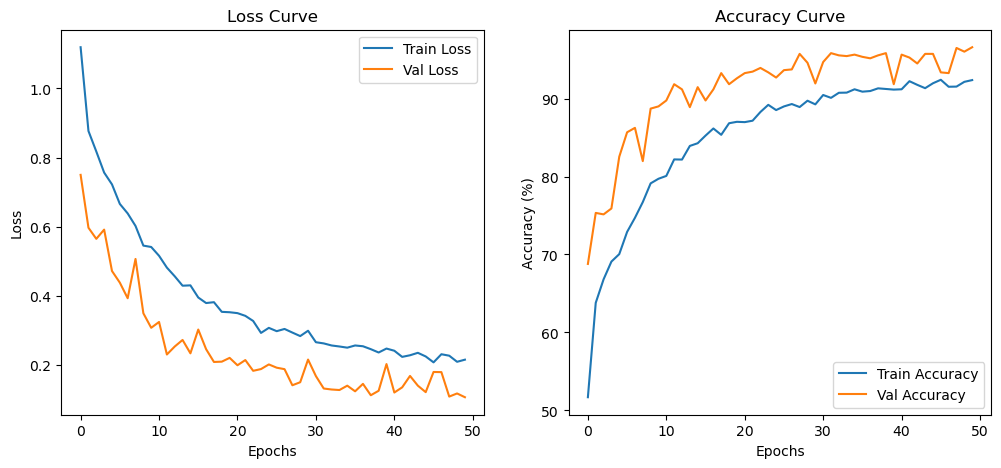

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Accuracy Curve")

plt.show()

Testing the trained model

In [ ]:
def test(model, test_loader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

test(model, test_loader)

Test Accuracy: 95.36%


Saving the trained model

In [ ]:
torch.save(model.state_dict(), "cnn.pth")

Load the saved model for evaluation

In [ ]:
model = CNN(num_classes=4).to(device)
model.load_state_dict(torch.load("cnn.pth"))
model.eval()

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=48384, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=4, bias=True)
  )
)

Collect all predictions and labels

In [ ]:
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

Classification report

In [ ]:
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))


Classification Report:
              precision    recall  f1-score   support

      glioma       0.97      0.94      0.95       452
  meningioma       0.91      0.96      0.93       449
     notumor       0.99      0.98      0.99       553
   pituitary       0.98      0.97      0.97       493

    accuracy                           0.96      1947
   macro avg       0.96      0.96      0.96      1947
weighted avg       0.96      0.96      0.96      1947



Confusion matrix

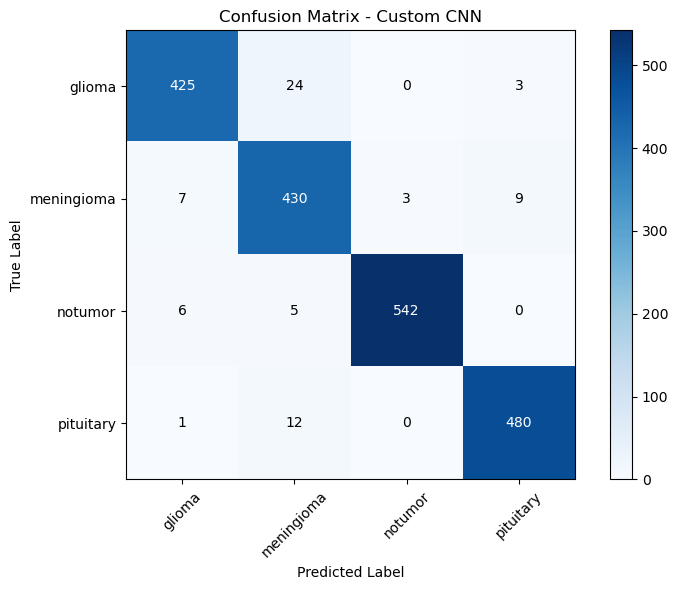

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Custom CNN')
plt.colorbar()
tick_marks = np.arange(len(test_dataset.classes))
plt.xticks(tick_marks, test_dataset.classes, rotation=45)
plt.yticks(tick_marks, test_dataset.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.show()

_____________________________________________________________________________

## Transfer learning on ResNet 18

In [19]:
data_dir = "split"
train_dir = f"{data_dir}/train"
val_dir = f"{data_dir}/val"
test_dir = f"{data_dir}/test"

Loading the dataset

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((150, 168)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomResizedCrop((150, 168), scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((150, 168)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_test_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=val_test_transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print("Dataset loading successful!")

Dataset loading successful!


Load Pretrained ResNet-18

In [ ]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features  
model.fc = nn.Linear(num_ftrs, 4) 

model = model.to(device)

Initialize loss function & optimizer

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Training function

In [ ]:
def resnet_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_losses, val_losses = [], []
    train_acc, val_acc = [], []

    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_acc.append(100 * correct / total)

        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_acc.append(100 * correct / total)

        end_time = time.time()
        print(f"Epoch {epoch+1}/{epochs}, Time: {end_time - start_time:.2f}s")
        print(f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc[-1]:.2f}%")
        print(f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc[-1]:.2f}%\n")

    return train_losses, val_losses, train_acc, val_acc

Model training

In [24]:
train_losses, val_losses, train_acc, val_acc = resnet_model(model, train_loader, val_loader, criterion, optimizer, epochs=50)

Epoch 1/50, Time: 33.30s
Train Loss: 0.4339, Train Acc: 85.18%
Val Loss: 0.4142, Val Acc: 84.52%

Epoch 2/50, Time: 29.04s
Train Loss: 0.2783, Train Acc: 90.53%
Val Loss: 0.3466, Val Acc: 87.79%

Epoch 3/50, Time: 29.21s
Train Loss: 0.2349, Train Acc: 91.81%
Val Loss: 0.2265, Val Acc: 92.03%

Epoch 4/50, Time: 29.32s
Train Loss: 0.1995, Train Acc: 93.17%
Val Loss: 0.1610, Val Acc: 94.48%

Epoch 5/50, Time: 29.58s
Train Loss: 0.1746, Train Acc: 94.07%
Val Loss: 0.1482, Val Acc: 94.79%

Epoch 6/50, Time: 29.76s
Train Loss: 0.1689, Train Acc: 94.07%
Val Loss: 0.1026, Val Acc: 96.37%

Epoch 7/50, Time: 30.04s
Train Loss: 0.1652, Train Acc: 94.35%
Val Loss: 0.0786, Val Acc: 97.50%

Epoch 8/50, Time: 29.26s
Train Loss: 0.1486, Train Acc: 94.88%
Val Loss: 0.0914, Val Acc: 97.24%

Epoch 9/50, Time: 29.23s
Train Loss: 0.1406, Train Acc: 95.26%
Val Loss: 0.1473, Val Acc: 94.94%

Epoch 10/50, Time: 29.13s
Train Loss: 0.1272, Train Acc: 95.40%
Val Loss: 0.1223, Val Acc: 95.09%

Epoch 11/50, Time: 

## ResNet18 model evaluation

Plotting the accuracies and the loss

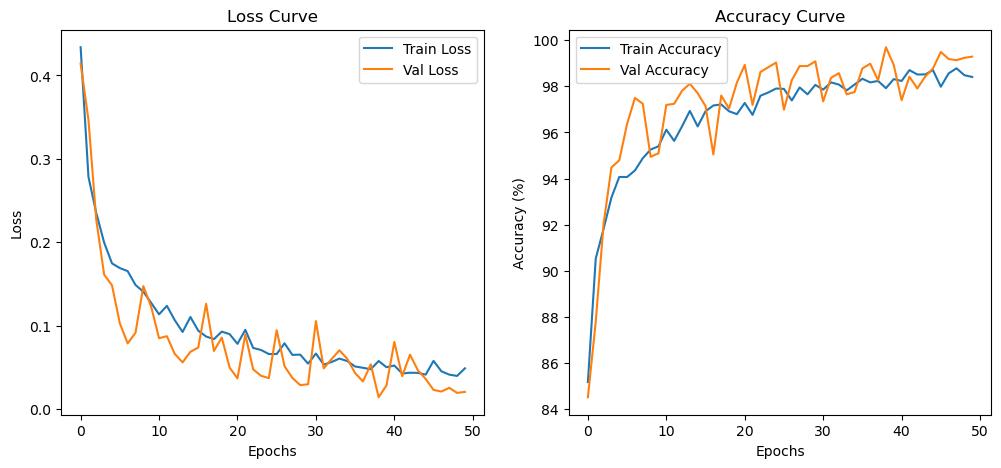

In [25]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(train_acc, label="Train Accuracy")
plt.plot(val_acc, label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Accuracy Curve")

plt.show()

Testing the model

In [26]:
def test_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    test_accuracy = 100 * correct / total
    print(f"\nTest Accuracy: {test_accuracy:.2f}%")

test_model(model, test_loader)


Test Accuracy: 99.33%


Save the model

In [27]:
torch.save(model.state_dict(), "resnet18.pth")

Load the saved model

In [28]:
model = resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 4)
model.load_state_dict(torch.load("resnet18.pth"))
model = model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Collect all predictions and labels

In [29]:
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

Classification report

In [30]:
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))


Classification Report:
              precision    recall  f1-score   support

      glioma       0.98      1.00      0.99       452
  meningioma       1.00      0.98      0.99       449
     notumor       0.99      1.00      1.00       553
   pituitary       1.00      0.99      0.99       493

    accuracy                           0.99      1947
   macro avg       0.99      0.99      0.99      1947
weighted avg       0.99      0.99      0.99      1947



Plot confusion matrix

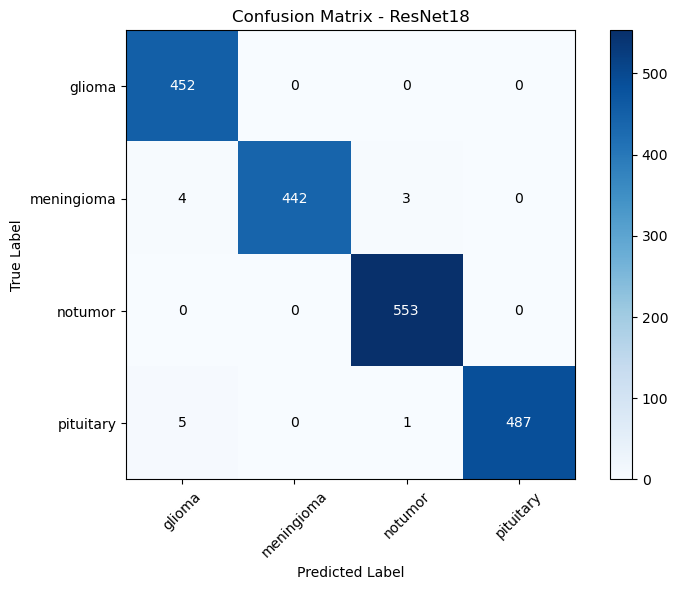

In [31]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - ResNet18')
plt.colorbar()
tick_marks = np.arange(len(test_dataset.classes))
plt.xticks(tick_marks, test_dataset.classes, rotation=45)
plt.yticks(tick_marks, test_dataset.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.show()